In [50]:
"""
.. _reconst_sfm:

==============================================
Reconstruction with the Sparse Fascicle Model
==============================================

In this example, we will use the Sparse Fascicle Model (SFM) [Rokem2015]_, to
reconstruct the fiber Orientation Distribution Function (fODF) in every voxel.

First, we import the modules we will use in this example:
"""

import os
import h5py
import numpy as np
import gc
import dipy.reconst.sfm as sfm
from dipy.reconst.odf import gfa, minmax_normalize

import dipy.data as dpd
import dipy.direction.peaks as dpp
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.viz import window, actor
from PIL import Image
import matplotlib.pyplot as plt
import copy

import yaml
from yaml import Loader

class Parameters:
    def __init__(self, orientation: str, 
                 slice_ind: int, 
                 matlab_area_TL: tuple, 
                 matlab_area_DR: tuple, 
                 directory: str,
                 orientationDict,
                 dictionary):
        self.orientation = orientation
        self.slice_ind = slice_ind
        self.matlab_area_TL = matlab_area_TL
        self.matlab_area_DR = matlab_area_DR
        # translate coordinates from Matlab (origin bottom right) to the origins in the odf Slicer and for the rectangle drawing in the end
        self.slicer_area_TL, self.slicer_area_DR = self.coosMatlab2Slicer(orientationDict['standard'])
        self.rect_area_TL, self.rect_area_DR = self.coosMatlab2Rect(orientationDict['standard'])
        self.directory = directory
        self.dictionary = dictionary
        
        self.ensureDirectoryExists()

    
    def coosMatlab2Slicer(self, standardShape):
        N_y,N_x,N_z,N_q = standardShape
        # TL = x0,y0 DR = x1,y1
        x0 = self.matlab_area_TL[1]
        y0 = self.matlab_area_TL[0]
        x1 = self.matlab_area_DR[1]
        y1 = self.matlab_area_DR[0]
        
        if self.orientation == 'tra':
            #TODO: check if actually working
            areaTLNew = (y0, N_x - x0+1)
            areaDRNew = (y1-1, N_x - x1)
        elif self.orientation == 'cor':
            areaTLNew = (N_z-y1-1, N_x -x1)
            areaDRNew = (N_z-y0, N_x -x0-1)
        return areaTLNew, areaDRNew
    
    def coosMatlab2Rect(self, standardShape):
        N_y,N_x,N_z,N_q = standardShape
        # TL = x0,y0 DR = x1,y1
        x0 = self.matlab_area_TL[1]
        y0 = self.matlab_area_TL[0]
        x1 = self.matlab_area_DR[1]
        y1 = self.matlab_area_DR[0]
        if self.orientation == 'tra':
            #TODO: implement correct orientation here
            areaTLNew = (y0, N_x - x0)
            areaDRNew = (y1, N_x - x1)
        elif self.orientation == 'cor':
            areaTLNew = (N_z-y0-1, N_x -x0)
            areaDRNew = (N_z-y1, N_x -x1 - 1)
        return areaTLNew, areaDRNew
    
    def ensureDirectoryExists(self):
        if not os.path.exists(self.directory):
            os.makedirs(self.directory)

    def createConfigTxt(self):
        completeName = os.path.join(self.directory, "parameters.txt")

        txtFile = open(completeName, "w")

        txtFile.write("Parameters used:\n\n")
        txtFile.write(Parameters.__str__(self))
        txtFile.close()

    def __str__(self) -> str:
        output_str = ''
        output_str += f'> used orientation: {self.orientation}\n'
        output_str += f'> used slice_ind: {self.slice_ind}\n'
        output_str += f'> used matlab_area_TL: {self.matlab_area_TL}\n'
        output_str += f'> used matlab_area_DR: {self.matlab_area_DR}\n'
        return output_str


def remove_black_borders(image_path, output_path, template=None, template_path=None):
    # Open the image
    if template:
        tmp = Image.open(template_path).convert("RGBA")
        img = Image.open(image_path).convert("RGBA")
    else:
        img = Image.open(image_path).convert("RGBA")
        tmp = img
    
    # Get the dimensions of the image
    width, height = img.size

    # Define the boundaries for cropping
    left, top, right, bottom = 0, 0, width, height

    # Scan from the top to find the first non-black row
    for y in range(height):
        row = tmp.crop((0, y, width, y + 1))
        if not all(pixel == (0, 0, 0, 255) for pixel in row.getdata()):
            top = y
            break

    # Scan from the bottom to find the last non-black row
    for y in range(height - 1, -1, -1):
        row = tmp.crop((0, y, width, y + 1))
        if not all(pixel == (0, 0, 0, 255) for pixel in row.getdata()):
            bottom = y + 1
            break

    # Scan from the left to find the first non-black column
    for x in range(width):
        column = tmp.crop((x, 0, x + 1, height))
        if not all(pixel == (0, 0, 0, 255) for pixel in column.getdata()):
            left = x
            break

    # Scan from the right to find the last non-black column
    for x in range(width - 1, -1, -1):
        column = tmp.crop((x, 0, x + 1, height))
        if not all(pixel == (0, 0, 0, 255) for pixel in column.getdata()):
            right = x + 1
            break
    
    # Crop the image using the found boundaries
    cropped_img = img.crop((left, top, right, bottom))
    
    # Save the cropped image
    cropped_img.save(output_path)

def normalize_path(path):
    """
    Normalize a file path to be platform-independent and usable in Python.
    
    Parameters:
        path (str): The file path as copied from Windows or Linux.
        
    Returns:
        str: The normalized path.
    """
    # Replace backslashes with forward slashes for initial consistency
    path = path.replace("\\", "/")
    # Use os.path.normpath to make it platform-specific
    normalized_path = os.path.normpath(path)

    if not os.path.splitext(normalized_path)[1]:  # No file extension
        # Append a trailing slash or backslash based on the OS
        if not normalized_path.endswith(os.sep):
            normalized_path += os.sep

    return normalized_path

def load_data(key, path_to_data, params, odf_calc, orientationDict):
    dataFile = h5py.File(path_to_data + key +  os.sep + params.dictionary[key]+'.h5', 'r')
    if key == 'lpca':
        if odf_calc:
            data = abs(dataFile['DWI'][:])* 1000
        FA   = dataFile['FA_lam_0'][:]
        print('>> FA lpca shape:',FA.shape)
    else:
        if odf_calc:
            data = abs(dataFile['DWI'][:].T)* 1000
        if key == 'muse':
            FA = dataFile['FA_lam_0'][:]
            print('>> FA muse shape:',FA.shape)
        else:
            try:
                FA   = dataFile['fa'][:]
            except:
                FA = dataFile['FA'][:]
            finally:
                print('Didnt work')
            print('>> FA dec shape:',FA.shape)
    dataFile.close()

    # flip z-axis, because it is necessary from standard data shape #TODO: evaluate if necessary for tra and sag
    if odf_calc:
        
        try:
            assert data.shape == tuple(orientationDict['standard'])
        except AssertionError as e:
            try:
                data = data.T
                assert data.shape == tuple(orientationDict['standard'])
                print('data was transposed')
                
            except AssertionError as e2:
                print("Assertion failed")
                raise
    if params.orientation == 'cor':
        data = np.flip(data, 2)
        FA = np.flip(FA, 2)

    return data, FA

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

seq_path = normalize_path('..\\raw-data\\data-126-dir\\1.0mm_126-dir_R3x3_dvs.h5')

seqInfo = h5py.File(seq_path, 'r')
bvals   = seqInfo['bvals'][:]
bvecs   = seqInfo['bvecs'][:]
seqInfo.close()

gtab = gradient_table(bvals, bvecs, atol=3e-2)

path_to_data = config['path_to_data']
path_to_data = normalize_path(path_to_data)
dictionary = config['dictionary']
data_dict = {'muse': {'data':None,'FA':None}, 'llr': {'data':None,'FA':None}, 'dec':{'data':None,'FA':None}}
# dictionary = {'muse': 'MuseRecon_combined_slices', 'llr': 'JETS2', 'dec':'DecRecon_combined_slices','DTI': 'DecRecon_combined_slices'}

orientationDict = config['orientation_dict']
print(orientationDict['standard'])

areas_dict = config['areas_dict']

for area in areas_dict:
    # given the indices from Matlab ArrShow
    orientation = areas_dict[area]['orientation']
    slice_ind = areas_dict[area]['slice_ind']
    matlab_area_TL = areas_dict[area]['matlab_area_TL'] #y,x
    matlab_area_DR = areas_dict[area]['matlab_area_DR']  #y,x
    directory = area + os.sep

    params = Parameters(orientation, slice_ind, matlab_area_TL, matlab_area_DR, directory, orientationDict=orientationDict, dictionary=dictionary)

    # Enables/disables interactive visualization and sf_calc (primary diffusion direction)
    interactive = config['interactive']
    sf_calc = config['sf_calc']
    odf_calc = config['odf_calc']
    plot_joint_fig = config['plot_joint_fig']
    i=0


[200, 200, 114, 126]


In [51]:
data_dict = {'muse': {'data':None,'FA':None}, 'llr': {'data':None,'FA':None}, 'dec':{'data':None,'FA':None}}
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_key, key): key for key in data_dict}
    for future in concurrent.futures.as_completed(futures):
        key = futures[future]
        try:
            key, data, FA = future.result()
            data_dict[key]['data'] = data
            data_dict[key]['FA'] = FA
            print(f'>> Data and FA loaded for {key}')
        except Exception as e:
            print(f'Error processing {key}: {e}')

print("All data loaded:", data_dict)

Processing muse
Processing llr
Processing dec
>> FA muse shape: (200, 200, 114)
>> Data and FA loaded for muse
Didnt work
>> FA dec shape: (200, 200, 114)
>> Data and FA loaded for dec
Didnt work
>> FA dec shape: (200, 200, 114)
>> Data and FA loaded for llr
All data loaded: {'muse': {'data': array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0.

(200, 200, 114, 126)
(array([0.0004147 , 0.00012849, 0.00012849]), 0.024780099741092753)
(27, 28, 1, 126)
>> odf calc
(27, 28, 1)
(27, 28)
(27, 28, 1, 362)


c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\dipy\reconst\odf.py:98: RuntimeWarning: invalid value encountered in divide
  out /= (sample_maxes - sample_mins)
c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the projection function in future versions of FURY.

Here's how to call the Function projection: projection(self_value, proj_type='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


(200, 200, 114, 126)
(array([0.0008391 , 0.00021916, 0.00021916]), 0.03794000664645333)
(27, 28, 1, 126)
>> odf calc
(27, 28, 1)
(27, 28)
(27, 28, 1, 362)


c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\dipy\reconst\odf.py:98: RuntimeWarning: invalid value encountered in divide
  out /= (sample_maxes - sample_mins)
c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the projection function in future versions of FURY.

Here's how to call the Function projection: projection(self_value, proj_type='value')

  exec(code_obj, self.user_global_ns, self.user_ns)


(200, 200, 114, 126)
(array([0.00112877, 0.00022457, 0.00022457]), 0.04777969267686325)
(27, 28, 1, 126)
>> odf calc
(27, 28, 1)
(27, 28)
(27, 28, 1, 362)


c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\dipy\reconst\odf.py:98: RuntimeWarning: invalid value encountered in divide
  out /= (sample_maxes - sample_mins)
c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the projection function in future versions of FURY.

Here's how to call the Function projection: projection(self_value, proj_type='value')

  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\glaserjs\.conda\envs\laser\lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the record function in future versions of FURY.

Here's how to call the Function record: record(scene='value', cam_pos='value', cam_focal='value', cam_view='value', out_path='value', path_numbering='value', n_frames='value', az_ang='value', magnification='value', size='value', reset_camera='value', screen_clip='value', stereo='value', verbose='va

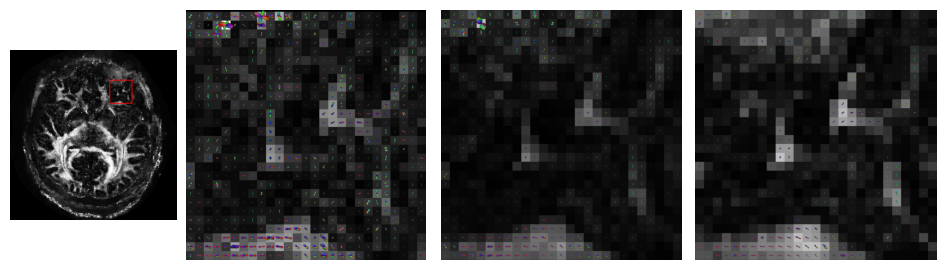

In [49]:
for key in dictionary:
    FA = data_dict[key]['FA']
    data = data_dict[key]['data']
    ###############################################################################
    # Reconstruction of the fiber ODF in each voxel guides subsequent tracking
    # steps. Here, the model is the Sparse Fascicle Model, described in
    # [Rokem2014]_. This model reconstructs the diffusion signal as a combination
    # of the signals from different fascicles. This model can be written as:
    #
    # .. math::
    #
    #     y = X\beta
    #
    # Where $y$ is the signal and $\beta$ are weights on different points in the
    # sphere. The columns of the design matrix, $X$ are the signals in each point
    # in the measurement that would be predicted if there was a fascicle oriented
    # in the direction represented by that column. Typically, the signal used for
    # this kernel will be a prolate tensor with axial diffusivity 3-5 times higher
    # than its radial diffusivity. The exact numbers can also be estimated from
    # examining parts of the brain in which there is known to be only one fascicle
    # (e.g. in corpus callosum).
    #
    # Sparsity constraints on the fiber ODF ($\beta$) are set through the Elastic
    # Net algorithm [Zou2005]_.
    #
    # Elastic Net optimizes the following cost function:
    #
    # .. math::
    #
    #     \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \alpha (\lambda \sum_{j=1}^{m}{w_j}+(1-\lambda) \sum_{j=1}^{m}{w^2_j}
    #
    # where $\hat{y}$ is the signal predicted for a particular setting of $\beta$,
    # such that the left part of this expression is the squared loss function;
    # $\alpha$ is a parameter that sets the balance between the squared loss on
    # the data, and the regularization constraints. The regularization parameter
    # $\lambda$ sets the `l1_ratio`, which controls the balance between L1-sparsity
    # (low sum of weights), and low L2-sparsity (low sum-of-squares of the
    # weights).
    #
    # Just like Constrained Spherical Deconvolution (see :ref:`reconst-csd`), the
    # SFM requires the definition of a response function. We'll take advantage of
    # the automated algorithm in the :mod:`csdeconv` module to find this response
    # function:
    if odf_calc:
        print(data.shape)
        response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.75)

    ###############################################################################
    # The ``response`` return value contains two entries. The first is an array
    # with the eigenvalues of the response function and the second is the average
    # S0 for this response.
    #
    # It is a very good practice to always validate the result of
    # ``auto_response_ssst``. For, this purpose we can print it and have a look
    # at its values.

        print(response)

    ###############################################################################
    # We initialize an SFM model object, using these values. We will use the
    # default sphere (362  vertices, symmetrically distributed on the surface of
    # the sphere), as a set of putative fascicle directions that are considered
    # in the model

        sphere = dpd.get_sphere()
        sf_model = sfm.SparseFascicleModel(gtab, sphere=sphere,
                                        l1_ratio=0.5, alpha=0.001,
                                        response=response[0])

    # define smaller area of the whole slice to plot and use the transformed coordinates accordingly
    if params.orientation == 'tra':
        if odf_calc:
            data_small = data[params.slicer_area_DR[1]:params.slicer_area_TL[1],
                            params.slicer_area_DR[0]:params.slicer_area_TL[0], 
                            params.slice_ind:params.slice_ind+1]
        FA_small   = FA[params.slicer_area_DR[1]:params.slicer_area_TL[1], 
                        params.slicer_area_DR[0]:params.slicer_area_TL[0], 
                        params.slice_ind:params.slice_ind+1]
    elif params.orientation == 'cor':
        if odf_calc:
            data_small = data[params.slicer_area_TL[1]:params.slicer_area_DR[1], 
                            params.slice_ind:params.slice_ind+1, 
                            params.slicer_area_DR[0]:params.slicer_area_TL[0]]
        FA_small   = FA[params.slicer_area_TL[1]:params.slicer_area_DR[1], 
                        params.slice_ind:params.slice_ind+1, 
                        params.slicer_area_DR[0]:params.slicer_area_TL[0]]

    ###############################################################################
    # Fitting the model to this small volume of data, we calculate the ODF of this
    # model on the sphere, and plot it.
    if odf_calc:
        print(data_small.shape)
        print('>> odf calc')
        sf_fit = sf_model.fit(data_small)
        FA_scale = copy.deepcopy(FA_small)
        sf_odf = sf_fit.odf(sphere)
        gfa_scale = gfa(sf_odf)
        print(FA_scale.shape)
        print(gfa_scale.shape)
        scaling = FA_scale[...,None]/gfa_scale[:,:,None,None]
        sf_odf = minmax_normalize(sf_odf)*scaling
        # sf_odf = sf_odf*FA_scale[...,np.newaxis]
        print(sf_odf.shape)

    # slicer output is rotated by 90 degrees counter clockwise compared to input data
        fodf_spheres = actor.odf_slicer(sf_odf, sphere=sphere, scale=0.35, norm=False, colormap=None) #scale changes the size of odf plots (but not completely in ratio)

    background = actor.slicer(FA_small, interpolation='nearest', value_range=(0,1))

    scene = window.Scene()
    scene.projection('parallel')
    scene.background((0, 0, 0))
    if odf_calc:
        odf_path = params.directory +key + '_sf_odfs_'+params.orientation+'.png'
    fa_path  = params.directory +key + '_FA_'+params.orientation+'.png'
    if params.orientation == 'tra':
        # background.display_extent(0,
        #                         FA_small.shape[0] - 1,
        #                         0,
        #                         0,
        #                         0,
        #                         FA_small.shape[2] - 1)
        background.SetPosition(0, 0, 1) # move background behind ODFs
        scene.add(background)
        scene.set_camera(position=(0,0,-20),
                        focal_point=(0,0,0),
                        view_up=(0,1,0))
        window.record(scene=scene, out_path=fa_path , size=(3000, 3000))
        # remove annoying black border from image
        if odf_calc:
        #     fodf_spheres.display_extent(0,
        #                             data_small.shape[0] - 1,
        #                             0,
        #                             0,
        #                             0,
        #                             data_small.shape[2] - 1)
            fodf_spheres.SetPosition(0,0,-10)
            scene.add(fodf_spheres)
    elif params.orientation=='cor':
        # for other orientation than tra the area to view has to be adapted
        # and for coronal the camera position has to be changed for accurate depiction
        # TODO: search for smoother way to do this
        
        background.display_extent(0,
                                FA_small.shape[0] - 1,
                                0,
                                0,
                                0,
                                FA_small.shape[2] - 1)
        background.SetPosition(0, 1, 0) # move background behind ODFs
        scene.add(background)
        scene.set_camera(position=(0,-1,0),
                        focal_point=(0,0,0),
                        view_up=(0,0,-1))
        window.record(scene, out_path=fa_path , size=(3000, 3000))
        # remove annoying black border from image
        if odf_calc:
            fodf_spheres.display_extent(0,
                                    data_small.shape[0] - 1,
                                    0,
                                    0,
                                    0,
                                    data_small.shape[2] - 1)
            scene.add(fodf_spheres)
        

    if odf_calc:
        # save the generated scene (odfs and FA in background)
        window.record(scene=scene, out_path=odf_path, size=(3000,3000))
        # remove annoying black border from image
        remove_black_borders(odf_path, odf_path)
    if interactive:
        window.show(scene)

    remove_black_borders(fa_path , fa_path)

    # save the generated scene (FA)

    ###############################################################################
    # We can extract the peaks from the ODF, and plot these as well

    i= i+1
    ###############################################################################
    # .. rst-class:: centered small fst-italic fw-semibold
    #
    # SFM Peaks and ODFs.
    #
    #
    # To see how to use this information in tracking, proceed to :ref:`sfm-track`.
    #
    # References
    # ----------
    #
    # .. [Rokem2015] Ariel Rokem, Jason D. Yeatman, Franco Pestilli, Kendrick
    #    N. Kay, Aviv Mezer, Stefan van der Walt, Brian A. Wandell
    #    (2015). Evaluating the accuracy of diffusion MRI models in white
    #    matter. PLoS ONE 10(4): e0123272. doi:10.1371/journal.pone.0123272
    #
    # .. [Zou2005] Zou H, Hastie T (2005). Regularization and variable
    #    selection via the elastic net. J R Stat Soc B:301-320


    scene.clear()
    
    if key == 'dec':
        if params.orientation == 'tra':
            #TODO: implement
            background = actor.slicer(FA[:, :, params.slice_ind:params.slice_ind+1], interpolation='nearest')
            background.display_extent(0,
                                        FA.shape[0] - 1,
                                        0,
                                        FA.shape[1] - 1,
                                        0,
                                        0)
            x0 = params.rect_area_TL[1]
            x1 = params.rect_area_DR[1]
            y0 = params.rect_area_TL[0]
            y1 = params.rect_area_DR[0]
            lines = np.array([[[x0,y1,0], [x1,y1,0]], 
                            [[x1,y1,0], [x1,y0,0]],
                            [[x1,y0,0], [x0,y0,0]],
                            [[x0,y0,0], [x0,y1,0]]])
        elif params.orientation == 'cor':
            background = actor.slicer(FA[100:180, params.slice_ind:params.slice_ind+1, :], interpolation='nearest')
            background.display_extent(0,
                                        80 - 1,
                                        0,
                                        0,
                                        0,
                                        FA.shape[1] - 1)
            x0 = params.rect_area_TL[1]-100
            x1 = params.rect_area_DR[1]-99
            y0 = params.rect_area_DR[0]
            y1 = params.rect_area_TL[0]+1
            lines = np.array([[[x0,0,y1], [x1,0,y1]], 
                            [[x1,0,y1], [x1,0,y0]],
                            [[x1,0,y0], [x0,0,y0]],
                            [[x0,0,y0], [x0,0,y1]]])
            
        # lines = np.array([[[areaTL[0],areaTL[1],0], [areaDR[0],areaTL[1], 0]], [[areaTL[0],areaTL[1],0],[areaTL[0],areaDR[1], 0]], [[areaDR[0],areaDR[1],0], [areaTL[0],areaDR[1], 0]], [[areaDR[0],areaTL[1], 0], [areaDR[0],areaDR[1],0]] ])

        # Create a line actor to draw the rectangle border (passing vertices and connectivity)
        rectangle_border = actor.line(lines, colors=(1, 0, 0), opacity=1.0,linewidth=10.0)

        # Add the rectangle border actor to the scene

        scene.add(background)
        scene.add(rectangle_border)

        highlighted_fa_path = params.directory +'FA_plus_highlight.png'

        window.record(scene, out_path=highlighted_fa_path, size=(3000, 2800))
        remove_black_borders(highlighted_fa_path , highlighted_fa_path)

if plot_joint_fig:
    img1 = plt.imread(params.directory +'FA_plus_highlight.png')
    imgs = []
    for key in dictionary:
        imgs.append(plt.imread(params.directory + key + '_sf_odfs_'+params.orientation+'.png'))

    fig = plt.figure(figsize=(5, 5))

    # Non-quadratic image
    ax1 = fig.add_axes([0.1, 0.1, 0.332, 0.5])  # [left, bottom, width, height]
    ax1.imshow(img1)
    ax1.axis('off')

    # ODF + FA images
    i=0
    for image in imgs:
        ax = fig.add_axes([0.442+0.51*i, 0.1, 0.5, 0.5])
        ax.imshow(image)
        ax.axis('off')
        i=i+1
    plt.show()
    # plt.savefig(params.directory +'combined_odfs.png', bbox_inches='tight', dpi=1500)
    # plt.savefig(params.directory +'combined_odfs.pdf', bbox_inches='tight', dpi=1500)


params.createConfigTxt()
